In [9]:
import pandas as pd

In [10]:
try:
    df_imdb = pd.read_csv("imdb_top_1000.csv")
    print('Dataset cargado con éxito.')    
except FileNotFoundError:
    print(f"No se encontró el archivo. Verifica la ruta e intenta de nuevo.")

# Primeras 5 filas del dataset
df_imdb.head()

Dataset cargado con éxito.


,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [11]:
# Cantidad de filas y columnas del dataset
df_imdb.shape

(1000, 16)

In [12]:
# Tipo de datos por columnas
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [13]:
# Muestra estadística por las columnas numéricas
df_imdb.describe()

,IMDB_Rating,Meta_score,No_of_Votes
count,1000.000000,843.000000,1.000000e+03
mean,7.949300,77.971530,2.736929e+05
std,0.275491,12.376099,3.273727e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.552625e+04
50%,7.900000,79.000000,1.385485e+05
75%,8.100000,87.000000,3.741612e+05
max,9.300000,100.000000,2.343110e+06


In [14]:
# Cantidad de valores únicos por columnas
for col in df_imdb:
    print(f"{col}: {df_imdb[col].nunique()} únicos")
# Certificate es la más categórica

Poster_Link: 1000 únicos
Series_Title: 999 únicos
Released_Year: 100 únicos
Certificate: 16 únicos
Runtime: 140 únicos
Genre: 202 únicos
IMDB_Rating: 17 únicos
Overview: 1000 únicos
Meta_score: 63 únicos
Director: 548 únicos
Star1: 660 únicos
Star2: 841 únicos
Star3: 891 únicos
Star4: 939 únicos
No_of_Votes: 999 únicos
Gross: 823 únicos


In [15]:
# Valores nulos por columna
print(df_imdb.isnull().sum())

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64


In [16]:
# LIMPIEZA DE DATOS

# Ajustar nombres de las columnas a minúsculas y reeplazar espacios con guiones bajos
df_imdb.columns = df_imdb.columns.str.lower().str.replace(' ', '_')

# Limpieza y conversión de Runtime a numérico
# Elimino el texto min y convierto a int
df_imdb['runtime_minutes'] = df_imdb['runtime'].str.replace(' min', '').astype(int)

# Limpieza y conversión de Released_Year 
df_imdb['released_year'] = pd.to_numeric(df_imdb['released_year'], errors='coerce').astype('Int64')

# Limpieza y conversión de Gross a numérico
df_imdb['gross'] = df_imdb['gross'].astype(str).str.replace(',', '')
df_imdb['gross'] = pd.to_numeric(df_imdb['gross'], errors='coerce')
# QUEDAN NULOS

# Manejo de nulos
df_imdb['certificate'] = df_imdb['certificate'].fillna('Unknown')
df_imdb['meta_score'] = df_imdb['meta_score'].fillna(df_imdb['meta_score'].mean())
df_imdb['gross'] = df_imdb['gross'].fillna(0)
df_imdb = df_imdb.dropna(subset='released_year')



In [26]:
# CARGA DE DATAFRAME A SQLITE
import sqlite3

# Cargo todo a una db SQLITE para simular que la data para el análisis proviene de una Base de Datos
db_file = 'db/imdb.db'

try:
    conn = sqlite3.connect(db_file)
    print(f"Conexión a la base de datos '{db_file}' establecida exitosamente.")

except sqlite3.Error as e:
    print(f"Error al conectar a la base de datos: {e}")
    
# Nombre de la tabla a la que se cargará el df
table_name = 'imdb_movies_clean'

# Cargo el df a SQLite

try:
    df_imdb.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"DataFrame cargado a la tabla '{table_name}' exitosamente.")
except Exception as e:
    print(f"Error al cargar el DataFrame a la base de datos: {e}")


Conexión a la base de datos 'db/imdb.db' establecida exitosamente.
DataFrame cargado a la tabla 'imdb_movies_clean' exitosamente.


In [18]:
# PREPARACIÓN PARA EL EDA Y VISUALIZACIÓN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configuración básica para los gráficos
sns.set_style("whitegrid") # Estilo de fondo para Seaborn
plt.rcParams['figure.figsize'] = (10, 6) # Tamaño por defecto para las figuras
plt.rcParams['font.size'] = 12 # Tamaño de fuente general
plt.rcParams['axes.labelsize'] = 14 # Tamaño de fuente para etiquetas de ejes
plt.rcParams['axes.titlesize'] = 16 # Tamaño de fuente para títulos
plt.rcParams['xtick.labelsize'] = 12 # Tamaño de fuente para etiquetas del eje X
plt.rcParams['ytick.labelsize'] = 12 # Tamaño de fuente para etiquetas del eje Y

--- Analizando: Top 5 Películas Mejor Valoradas ---


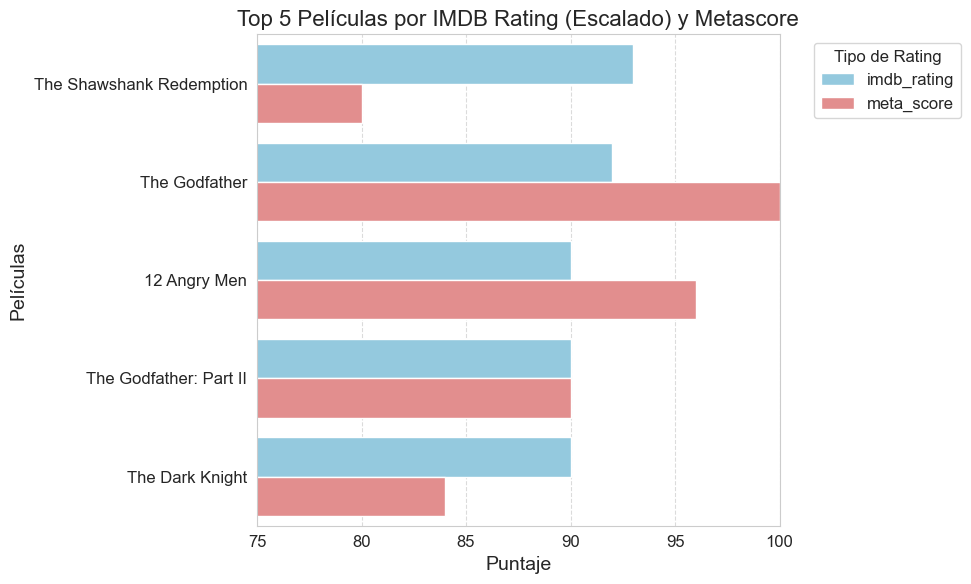

In [19]:
# PREGUNTA 1: TOP 5 PELÍCULAS MEJOR VALORADAS
print("--- Analizando: Top 5 Películas Mejor Valoradas ---")

try:
    # QUERY
    sql_query_1_file_path = 'sql/top_rated_movies.sql'
    with open(sql_query_1_file_path, 'r') as file:
        sql_q1 = file.read()
    df_top_movies = pd.read_sql_query(sql_q1, conn)

    # MINI LIMPIEZA - Multiplicar imdb_rating por 10 para igualar la escala de Meta Score
    df_top_movies['imdb_rating'] *= 10
    
    # VISUALIZACIÓN 
    # Convierto columnas a filas para mejor visualización
    df_melted = df_top_movies.melt(id_vars='series_title', 
                                   value_vars=['imdb_rating', 'meta_score'], 
                                   var_name='rating_type',
                                   value_name='score') 

    sns.barplot(
        x='score',
        y='series_title',
        hue='rating_type',
        data=df_melted,
        palette={'imdb_rating': 'skyblue', 'meta_score': 'lightcoral'}
    )

    plt.title('Top 5 Películas por IMDB Rating (Escalado) y Metascore')
    plt.xlabel('Puntaje')
    plt.ylabel('Películas')
    plt.xlim(df_melted['score'].min() - 5, df_melted['score'].max())
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(title='Tipo de Rating', bbox_to_anchor=(1.05, 1), loc='upper left' )
    plt.tight_layout()
    plt.show()    


except FileNotFoundError:
    print(f"Error, no se encuentra el archivo SQL en la ruta: {sql_query_1_file_path}.")
except Exception as e:
    print(f"Error, al ejecutar la consulta o visualizar la pregunta 1: {e}.")

--- Analizando la Distribución de los Ratings ---


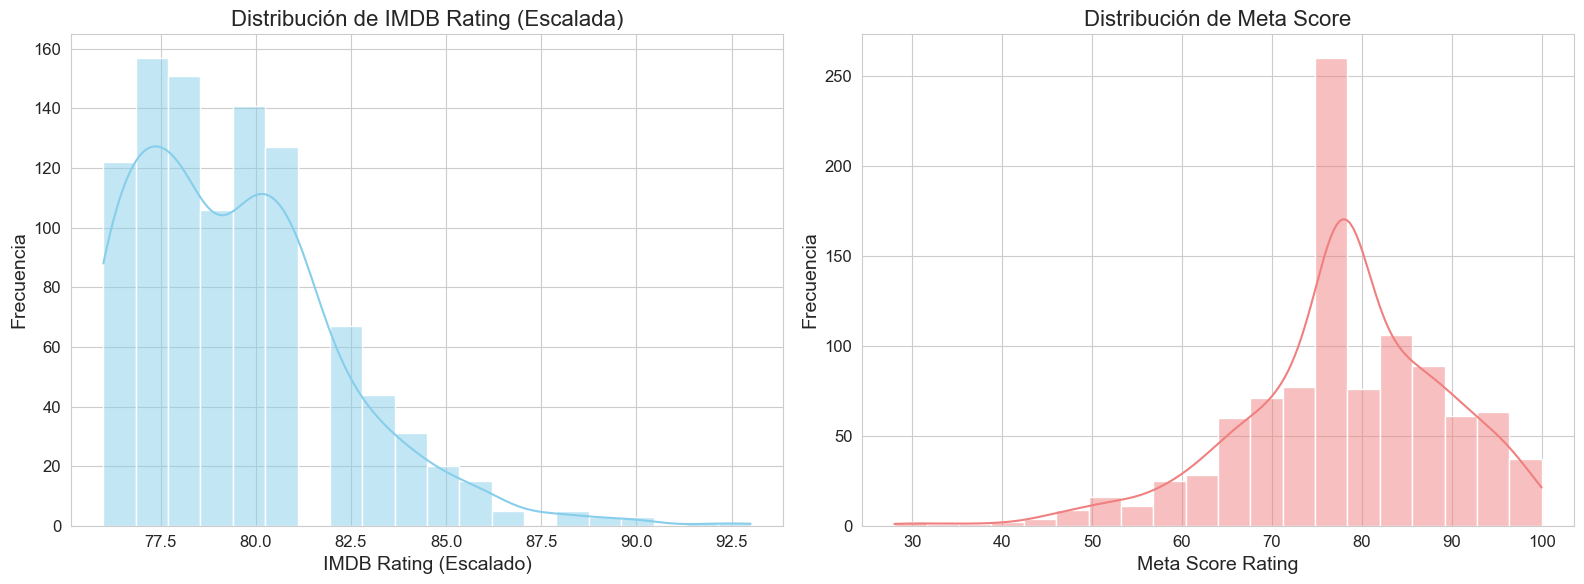

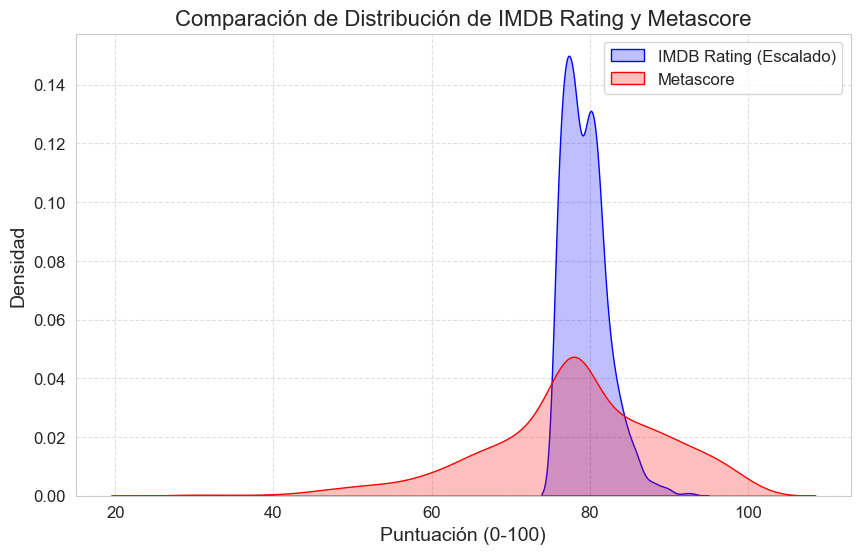

In [20]:
# PREGUNTA 2: DISTRIBUCIÓN DE CALIFICACIONES ENTRE IMDB Y META SCORE
print(f"--- Analizando la Distribución de los Ratings ---")


try:
    # QUERY
    sql_query_2_file_path = 'sql/rating_distribution.sql'
    with open(sql_query_2_file_path, 'r') as file:
        sql_q2 = file.read()
    df_distribution = pd.read_sql_query(sql_q2, conn)
    
    
    # Escalo IMDB rating para que sea comparable con Meta Score
    df_distribution['imdb_rating'] *= 10
    
    # VISUALIZACIÓN
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(df_distribution['imdb_rating'], kde=True, ax=axes[0], 
                 color='skyblue', bins=20)
    axes[0].set_title('Distribución de IMDB Rating (Escalada)')
    axes[0].set_xlabel('IMDB Rating (Escalado)')
    axes[0].set_ylabel("Frecuencia")
    
    sns.histplot(df_distribution['meta_score'], kde=True, ax=axes[1],
                 color='lightcoral', bins=20)
    axes[1].set_title('Distribución de Meta Score')
    axes[1].set_xlabel('Meta Score Rating')
    axes[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

    # Gráfico de densidad combinado
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df_distribution['imdb_rating'], label='IMDB Rating (Escalado)',
                color='blue', fill=True)
    sns.kdeplot(df_distribution['meta_score'], label='Metascore', color='red', fill=True)
    plt.title('Comparación de Distribución de IMDB Rating y Metascore')
    plt.xlabel('Puntuación (0-100)')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
        
except FileNotFoundError:
    print(f"Error, el documento SQL no se encuentra en el path: {sql_query_2_file_path}")
except Exception as e:
    print(f"Error al ejecutar el comando SQL o visualizar la pregunta 2: {e}")

--- Analizando la Distribución de los Genre's ---
Error al ejecutar el archivo SQL o mostrar la visualización: 'xxx' is not a valid value for ls; supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'.


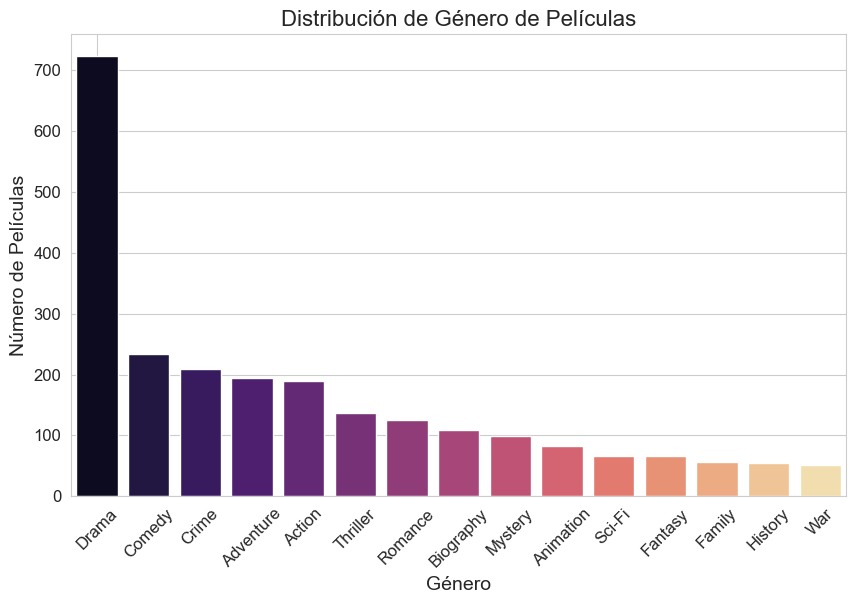

In [ ]:
# PREGUNTA 3: ¿Qué géneros de películas son los más comunes y cómo se distribuyen?
print(f"--- Analizando la Distribución de los Genre's ---")


try:
    # QUERY
    sql_query_3_path_file = 'sql/movies_genre.sql'
    with open(sql_query_3_path_file, 'r') as file:
        sql_3 = file.read()
    df_movies_genre_raw = pd.read_sql_query(sql_3, conn)
    
    
    # TRANSFORMACIÓN
    # Divido los diferentes géneros a una lista
    df_movies_genre_raw['genre_list'] = df_movies_genre_raw['genre'].str.split(', ')
    
    # Hago que cada género individual tenga su propia fila y elimino la columna genre
    df_movies_genre = df_movies_genre_raw.explode('genre_list').drop(columns='genre')
    
    # Cuento cada género único
    movies_genre = df_movies_genre['genre_list'].value_counts().reset_index()
    movies_genre.columns = ['genre', 'count']

    
    # VISUALIZACIÓN
    plt.Figure(figsize=(12, 8))
    sns.barplot(data=movies_genre.head(15),
                x='genre',
                y='count',
                palette='magma',
                hue='genre')
    plt.title('Distribución de Género de Películas')
    plt.xlabel('Género')
    plt.ylabel('Número de Películas')
    plt.xticks(rotation=45)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    

except FileNotFoundError:
    print(f"Error, el archivo SQL no se encuentra en el path: {sql_query_3_path_file}.")
except Exception as e:
    print(f"Error al ejecutar el archivo SQL o mostrar la visualización: {e}.")

In [22]:
# CIERRE DE LA CONEXIÓN CON LA BD
if 'conn' in locals() and conn is not None:
    try:
        conn.close()
        print(f"\nConexión a '{db_file}' cerrada.")
    except Exception as e:
        print(f"Error al cerrar la conexión: {e}")


Conexión a 'db/imdb.db' cerrada.
